### Import libraries

In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, to_categorical
from keras.utils import np_utils
from keras.optimizers import SGD

from PIL import Image
from io import BytesIO
import base64
from IPython.display import display, HTML
import dlib

### Data Exploration


In [2]:
# Set path
images_folder = 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000098.jpg'

TRAINING_SAMPLES = 15000
VALIDATION_SAMPLES = 2500
TEST_SAMPLES = 2500
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 15

### Load the attributes of every picture

In [3]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
print('shape of attribute is',df_attr.shape)

shape of attribute is (202599, 40)


### List all of the available attribute in the dataset


In [4]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    0
Male       0
Young      1
Name: 000098.jpg, dtype: int64

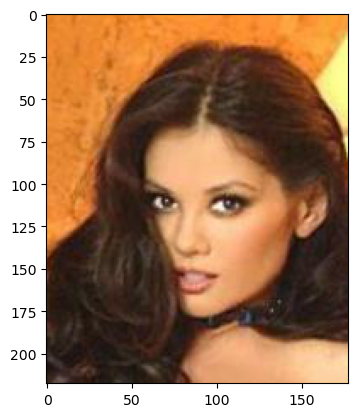

In [5]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

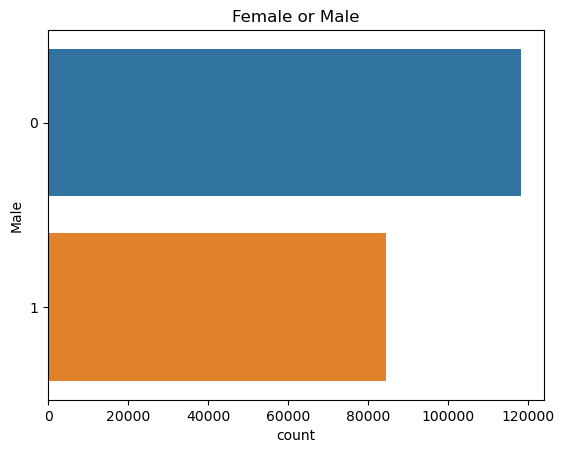

In [6]:
# Check distribution of gender, since we will only be working with the gender attribute
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr)
plt.show()

In [7]:
# Due to limited resources we will only be using part of the data
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [8]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same data frame

In [9]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


### 2.1: Generate Partitions (Train, Validation, Test)

Number of images need to be balanced in order to get a good performance for the model, each model will have its own folder of training, validation and test balanced data.

This degree project explains how imbalanced training data impact on CNNs models:

https://www.kth.se/social/files/588617ebf2765401cfcc478c/PHensmanDMasko_dkand15.pdf

On this step we will create functions that will help us to create each partition.

In [10]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    '''
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train, Validation, and Test
    x_ = []
    y_ = []

    # Load the pre-trained face detector from Dlib
    detector = dlib.get_frontal_face_detector()

    for index, target in df_.iterrows():
        # Load the input image
        image = cv2.imread(images_folder + index)
        tag = image.copy()
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image
        faces = detector(gray)

        if len(faces) > 0:
            face = faces[0]  # Assuming only one face is detected

            # Add inches to the face bounding box
            x, y, w, h = face.left(), face.top(), face.width(), face.height()

            # Adjust the coordinates for hair, ears, and mustache
            additional_height = int(h * 0.65)
            additional_width = int(w * 1.1)  
            y -= additional_height
            h += additional_height
            x -= additional_width // 2  
            w += additional_width

            # Ensure the coordinates are within the image boundaries
            x = max(0, x)
            y = max(0, y)
            x_end = min(tag.shape[1], x + w)
            y_end = min(tag.shape[0], y + h)
            cropped_image = tag[y:y_end, x:x_end]

            # Resize the cropped image to the desired dimensions
            resized_image = cv2.resize(cropped_image, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            resized_image = np.expand_dims(resized_image, axis=0)

            x_.append(resized_image)
            y_.append(target[attr])
            
    # Convert y_ to a numpy array and one-hot encode it
    y_ = np.array(y_)
    y_ = to_categorical(y_)

    return np.squeeze(np.array(x_)), y_

In [11]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

In [12]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

In [13]:
print(x_train.shape)
print(y_train.shape)

(14536, 218, 178, 3)
(14536, 2)


In [14]:
print(x_valid.shape)
print(y_valid.shape)

(2432, 218, 178, 3)
(2432, 2)


Build the Model - Gender Recognition

In [15]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [16]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [17]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

C:\Users\joshu\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Train Model

In [18]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [19]:
hist = model_.fit(x=x_train,y=y_train,
                      validation_data = (x_valid, y_valid),
                       steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE,
                       epochs= NUM_EPOCHS,
                       callbacks=[checkpointer],
                       verbose=1
                    )

Epoch 1/15
938/937 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.7841
Epoch 1: val_loss improved from inf to 0.23300, saving model to weights.best.inc.male.hdf5
937/937 [==============================] - 669s 709ms/step - loss: 0.4468 - accuracy: 0.7841 - val_loss: 0.2330 - val_accuracy: 0.9145
Epoch 2/15
938/937 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9021
Epoch 2: val_loss improved from 0.23300 to 0.16954, saving model to weights.best.inc.male.hdf5
937/937 [==============================] - 647s 690ms/step - loss: 0.2414 - accuracy: 0.9021 - val_loss: 0.1695 - val_accuracy: 0.9301
Epoch 3/15
938/937 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9279
Epoch 3: val_loss improved from 0.16954 to 0.14408, saving model to weights.best.inc.male.hdf5
937/937 [==============================] - 729s 778ms/step - loss: 0.1832 - accuracy: 0.9279 - val_loss: 0.1441 - val_accuracy: 0.9470
Epoch 4/15
938/937 [======

#### The best model after NUM_epech got an accuracy over the validation data of 96.41%.

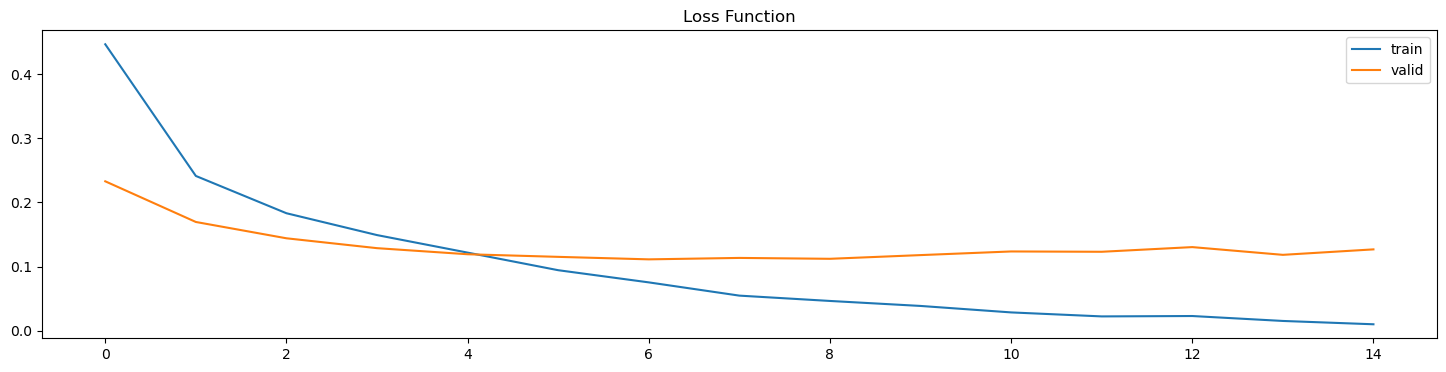

In [20]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

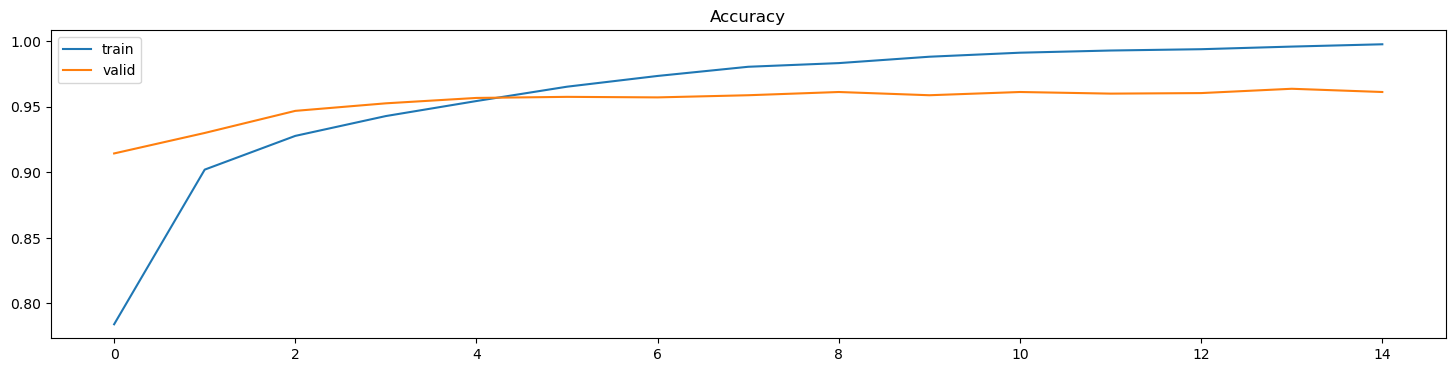

In [21]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

### 4.3. Model Evaluation

In [22]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [23]:
# save model
model_.save('Gender.h5')

In [24]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)


In [25]:
# generate prediction
model_predictions = model_.predict(x_test)

77/77 [==============================] - 25s 314ms/step


In [26]:
np.argmax(model_predictions[100])

0

In [27]:
np.argmax(y_test[100])

0

In [29]:
import tensorflow as tf
y_pred_classes = tf.argmax(model_predictions, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

accuracy = tf.metrics.Accuracy()

# Update the state of the accuracy object with the actual and predicted class labels
accuracy.update_state(y_test_classes, y_pred_classes)

# Fetch the result of the accuracy calculation
print("Accuracy: ", accuracy.result().numpy())

Accuracy:  0.95004094


#### Make predictions

In [30]:
def predict_gender(image_path, model_):
    IMG_WIDTH = 178
    IMG_HEIGHT = 218

    # Dictionary to name the prediction
    gender_target = {0: 'Female', 1: 'Male'}

    # Load the input image
    image = cv2.imread(image_path)
    tag = image.copy()
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained face detector from Dlib
    detector = dlib.get_frontal_face_detector()
    # Detect faces in the grayscale image
    faces = detector(gray)

    if len(faces) > 0:
        face = faces[0]  # Assuming only one face is detected

        # Add inches to the face bounding box
        x, y, w, h = face.left(), face.top(), face.width(), face.height()

        # Adjust the coordinates for hair, ears, and mustache
        additional_height = int(h * 0.65)
        additional_width = int(w * 1.1)  
        y -= additional_height
        h += additional_height
        x -= additional_width // 2  
        w += additional_width

        # Ensure the coordinates are within the image boundaries
        x = max(0, x)
        y = max(0, y)
        x_end = min(tag.shape[1], x + w)
        y_end = min(tag.shape[0], y + h)
        cropped_image = tag[y:y_end, x:x_end]

        # Resize the cropped image to the desired dimensions
        resized_image = cv2.resize(cropped_image, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
        resized_image = np.expand_dims(resized_image, axis=0)

        # Feed the image to the model
        prediction = model_.predict(resized_image)

        # Calculate prediction probability
        prediction_prob = np.max(prediction) * 100  # assuming model_.predict() gives output in [0, 1] range
        # Apply argmax to the prediction and map it to the corresponding label
        prediction = np.argmax(prediction)
        prediction = gender_target[prediction]
        
        # Draw bounding box and text on the image
        cv2.rectangle(image, (x, y), (x_end, y_end), (0, 0, 255), 2)
        cv2.putText(image, f'{prediction}: {prediction_prob:.2f}%', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        # Convert color space for correct display in matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Show image with matplotlib
        plt.imshow(image)
        plt.show()
        
        return prediction

    else:
        print("No face detected in the image.")
        return None


1/1 [==============================] - 0s 65ms/step


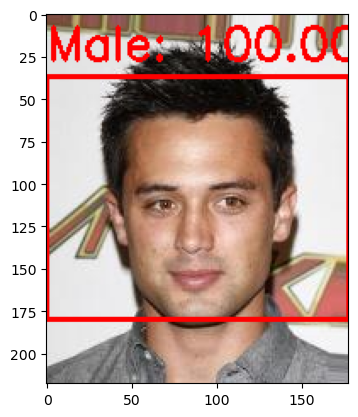

Male


In [31]:
images_folder = 'img_align_celeba/img_align_celeba/'
 

image_path = images_folder + '000007.jpg'
prediction = predict_gender(image_path, model_)
print(prediction)

#### Realtime

In [33]:
"""# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

# Dictionary to name the prediction
gender_target = {0: 'Female', 1: 'Male'}

# Start video capture from the webcam
print("Starting")
video_capture = cv2.VideoCapture(0)
time.sleep(2)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    if not ret:
        break

    # Convert the image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained face detector from Dlib
    detector = dlib.get_frontal_face_detector()
    # Detect faces in the grayscale image
    faces = detector(gray)

    if len(faces) > 0:
        for face in faces:
            # Add inches to the face bounding box
            x, y, w, h = face.left(), face.top(), face.width(), face.height()

            # Adjust the coordinates for hair, ears, and mustache
            additional_height = int(h * 0.65)
            additional_width = int(w * 1.1)  
            y -= additional_height
            h += additional_height
            x -= additional_width // 2  
            w += additional_width

            # Ensure the coordinates are within the image boundaries
            x = max(0, x)
            y = max(0, y)
            x_end = min(frame.shape[1], x + w)
            y_end = min(frame.shape[0], y + h)
            cropped_image = frame[y:y_end, x:x_end]

            # Resize the cropped image to the desired dimensions
            resized_image = cv2.resize(cropped_image, (178, 218)).astype(np.float32) / 255.0
            resized_image = np.expand_dims(resized_image, axis=0)

            # Feed the image to the model
            prediction = model_.predict(resized_image)

            # Calculate prediction probability
            prediction_prob = np.max(prediction) * 100  # assuming model_.predict() gives output in [0, 1] range
            # Apply argmax to the prediction and map it to the corresponding label
            prediction = np.argmax(prediction)
            prediction = gender_target[prediction]

            # Draw bounding box and text on the image
            cv2.rectangle(frame, (x, y), (x_end, y_end), (0, 0, 255), 2)
            cv2.putText(frame, f'{prediction}: {prediction_prob:.2f}%', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        # Display the frame with bounding box and prediction
        cv2.imshow('Video', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
video_capture.release()
cv2.destroyAllWindows()

"""

'# prevents openCL usage and unnecessary logging messages\ncv2.ocl.setUseOpenCL(False)\n\n# Dictionary to name the prediction\ngender_target = {0: \'Female\', 1: \'Male\'}\n\n# Start video capture from the webcam\nprint("Starting")\nvideo_capture = cv2.VideoCapture(0)\ntime.sleep(2)\n\nwhile True:\n    # Capture frame-by-frame\n    ret, frame = video_capture.read()\n\n    if not ret:\n        break\n\n    # Convert the image to grayscale\n    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)\n\n    # Load the pre-trained face detector from Dlib\n    detector = dlib.get_frontal_face_detector()\n    # Detect faces in the grayscale image\n    faces = detector(gray)\n\n    if len(faces) > 0:\n        for face in faces:\n            # Add inches to the face bounding box\n            x, y, w, h = face.left(), face.top(), face.width(), face.height()\n\n            # Adjust the coordinates for hair, ears, and mustache\n            additional_height = int(h * 0.65)\n            additional_width = 